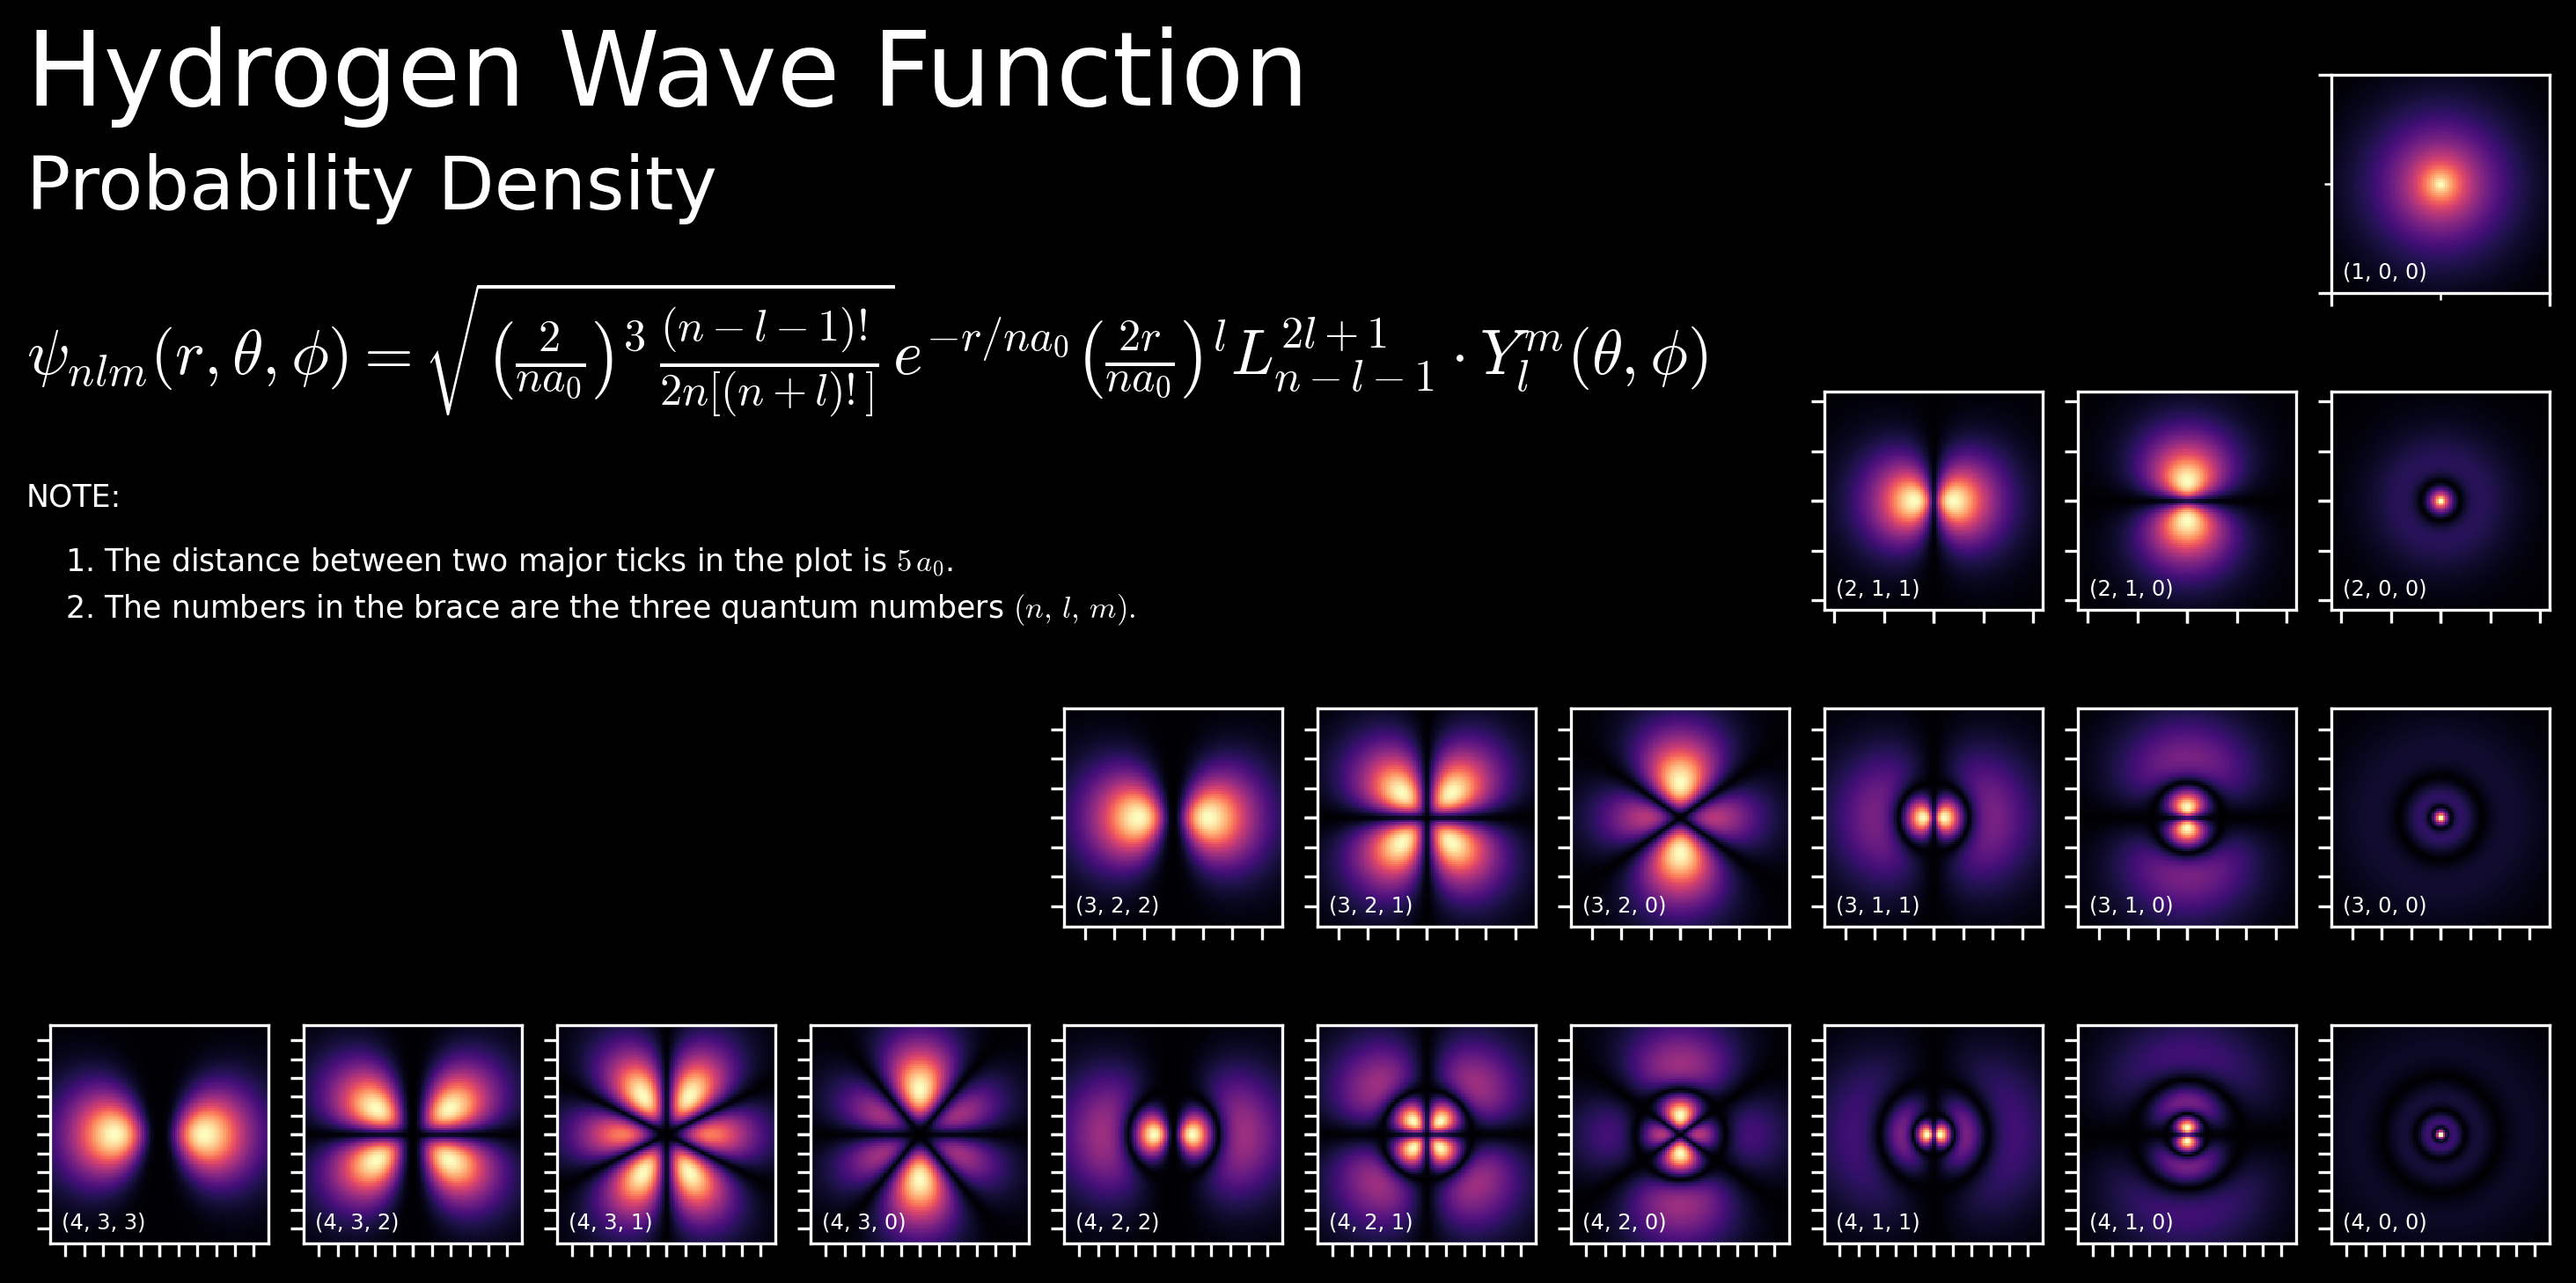

In [1]:
#!/usr/bin/env python

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

from sympy import lambdify, integrate, oo
from sympy.abc import r, theta, phi
from sympy.physics.hydrogen import R_nl, Psi_nlm

plt.style.use('dark_background')
mpl.rcParams['mathtext.fontset'] = 'cm'


def cart2sphe(x, y, z):
    '''
    3D Cartesian coordinates to spherical coordinates.

    input:
        x, y, z : numpy arrays
    '''
    xy2     = x**2 + y**2
    r       = np.sqrt(xy2 + z**2)    
    theta   = np.arctan2(np.sqrt(xy2), z) # the polar angle in radian angles
    phi     = np.arctan2(y, x)            # the azimuth angle in radian angles
    phi[phi < 0] += np.pi * 2             # np.arctan2 returns the angle in the range [-pi, pi]

    return r, theta, phi


################################################################################
if __name__ == "__main__":
    Nmax = 4
    nlms  = [
        (n, l, m)
        for n in range(1, Nmax+1)
        for l in range(n)
        for m in range(l+1)
    ]
    PSI  = [
        lambdify((r, phi, theta), Psi_nlm(n, l, m, r, phi, theta), 'numpy')
        for n, l, m in nlms
    ]

    ################################################################################
    # print(plt.figaspect(2 / Nmax),)
    fig = plt.figure(
        figsize=(9.6, 4.8),
        # figsize=plt.figaspect(2 / Nmax),
        dpi=300,
        constrained_layout=True
    )

    axes_array = np.zeros((Nmax, (Nmax*(Nmax+1))//2), dtype=int)
    axes_id    = 0
    for ii in range(Nmax):
        lm_sum = ((ii+1) * (ii+2)) // 2
        for jj in range(0, lm_sum):
            axes_id += 1
            axes_array[ii, -(jj+1)] = axes_id 

    axes = fig.subplot_mosaic(
        axes_array,
        empty_sentinel=0,
    )
    axes = [axes[ii+1] for ii in range(len(axes))]

    cut_planes = np.ones(len(axes), dtype=int) * 2
    ################################################################################

    for ii in range(len(axes)):
        n, l, m = nlms[ii]

        # L       = np.ceil(integrate(R_nl(n, l, r, Z=1)**2 * r**3, (r, 0, oo)) / 10) * 10
        # L       = integrate(R_nl(n, l, r, Z=1)**2 * r**3, (r, 0, oo)) * 2
        # N       = 100
        # print(n, l, L)

        if n == 1:
            L, N = 1.5*n**2 + 1.0, 100
        else:
            L, N = 1.5*n**2 + 5.0, 100

        a0, b0 = np.mgrid[
            -L:L:N*1j,
            -L:L:N*1j
        ]
        nx, ny = a0.shape
        xyz_planes_sphe = [
            cart2sphe(a0, b0, 0),
            cart2sphe(0, a0, b0),
            cart2sphe(a0, 0, b0),
        ]

        ax = axes[ii]
        ax.set_aspect(1.0)

        r0, theta, phi = xyz_planes_sphe[cut_planes[ii]]
        wfc = PSI[ii](r0, phi, theta).reshape(nx, ny)
        ax.pcolormesh(a0, b0, np.abs(wfc), cmap='magma') 

        ax.set_xlim(-L, L)
        ax.set_ylim(-L, L)

        STEP = 5
        if n == 1:
            ax.set_xticks([-2.5, 2.5])
            ax.set_yticks([-2.5, 2.5])
            ax.xaxis.set_minor_locator(AutoMinorLocator(n=2))
            ax.yaxis.set_minor_locator(AutoMinorLocator(n=2))
        else:
            ax.set_xticks([-x for x in np.arange(0, L, STEP)] + [x for x in np.arange(0, L, STEP)])
            ax.set_yticks([-x for x in np.arange(0, L, STEP)] + [x for x in np.arange(0, L, STEP)])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        ax.text(0.05, 0.05, "({}, {}, {})".format(n, l, m), 
                fontsize='xx-small',
                ha='left', va='bottom', transform=ax.transAxes, color='w')


    fig.text(0.0, 1.00,  r'Hydrogen Wave Function',
            fontsize=28,
            ha='left', va='top', transform=fig.transFigure, color='w')

    fig.text(0.0, 0.90,  r'Probability Density',
            fontsize=20,
            ha='left', va='top', transform=fig.transFigure, color='w')

    fig.text(0.0, 0.80,  r'$ \psi_{nlm}(r,\theta,\phi) = \sqrt{ \left(\frac{2}{na_0}\right)^3\, \frac{(n-l-1)!}{2n[(n+l)!]} } e^{-r / na_0} \left(\frac{2r}{na_0}\right)^l L_{n-l-1}^{2l+1}\cdot Y_l^m(\theta, \phi)$',
            fontsize='xx-large',
            ha='left', va='top', transform=fig.transFigure, color='w')

    # fig.text(0.00, 0.64,  "NOTE:\n\t1. The distance between two major ticks in the plot is $5\,a_0$,\n\t2. The number in the braces are the three quantum numbers $(n, l, m)$",
    #         fontsize='small',
    #         linespacing=1.8,
    #         ha='left', va='top', transform=fig.transFigure, color='w')

    fig.text(0.00, 0.64,  "NOTE:",
            fontsize='small',
            ha='left', va='top', transform=fig.transFigure, color='w')

    fig.text(0.00, 0.59,  "    1. The distance between two major ticks in the plot is $5\,a_0$.\n    2. The numbers in the brace are the three quantum numbers $(n,\,l,\,m).$",
            fontsize='small',
            linespacing=1.5,
            ha='left', va='top', transform=fig.transFigure, color='w')

    plt.savefig('hydro_wfc.png')

    # from subprocess import call
    # call('feh -xdF hydro_wfc.png'.split())